In [24]:
%run /home/user/besos/Matthias/tools/imports.ipynb
n_principal_components = 1
h = DataHandler(verbose=False, filename='/home/user/training_data/CAN_whole_fft_performed', region='CAN_whole')
def preprocess(X, y, standardization=None):
    
    if standardization is None:
        standardization = [StandardScaler() for i in range(2)]
        X = standardization[0].fit_transform(X)
        y = standardization[1].fit_transform(y)
    else:
        X = standardization[0].transform(X)
        y = standardization[1].transform(y)

    return X, y, standardization

def get_model_5(input_dim=n_principal_components, n_params=13, ls1=64, ls2=8, ls3=256, alpha=1e-8):
    inputs = Input(shape=(input_dim + n_params), name='inputs')
    
    weather = Lambda(lambda x: x[:,:input_dim], output_shape=(8760), name='weather')(inputs)
    params = Lambda(lambda x: x[:,-n_params:], output_shape=(n_params), name='params')(inputs)
    
    encoded_weather = Dense(ls1, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(alpha), name='endcoded_weather1')(weather)
    encoded_weather = Dense(ls2, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(alpha), name='endcoded_weather2')(encoded_weather)
    
    concat = Concatenate(name='concat')([encoded_weather, params])
    
    outputs = Dense(ls3, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(alpha),  name='hidden_1')(concat)
    outputs = Dense(1, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(alpha), name='outputs')(outputs)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse') #metrics=[coefficient_of_variance, relative_max_error]) -> implement these with tf backend functions!
    model.summary()
    
    return model

ann = KerasRegressor(build_fn=get_model_5, epochs=800, verbose=1)

Starting to load data from file...
Loaded 570 epw files.


In [25]:
X, y = read_samples('CAN', param_set=23, limit=10000, output_meter = 'DistrictHeating:Facility')
X_train, X_test, y_train,  y_test = train_test_split(pd.concat([X.iloc[:,:13], X.iloc[:,17]], axis=1), y, test_size=0.2, shuffle=True)
X_train, y_train, standardization = preprocess(X_train, y_train)
X_test, y_test, _ = preprocess(X_test, y_test, standardization)

In [26]:
estimator = copy.deepcopy(ann)

early_stopping = EarlyStopping(monitor='val_loss', patience=80, restore_best_weights=True)
history = estimator.fit(X_train, y_train, validation_split=0.2, callbacks=[early_stopping])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 14)]         0                                            
__________________________________________________________________________________________________
weather (Lambda)                (None, 1)            0           inputs[0][0]                     
__________________________________________________________________________________________________
endcoded_weather1 (Dense)       (None, 64)           128         weather[0][0]                    
__________________________________________________________________________________________________
endcoded_weather2 (Dense)       (None, 8)            520         endcoded_weather1[0][0]          
____________________________________________________________________________________________

Winnipeg        R2 score:    89.71 %, MAPE:   9.08 %, RMSPE:  9.96 %.
Ottawa          R2 score:    87.99 %, MAPE:  10.15 %, RMSPE: 10.81 %.
Longueuil       R2 score:    90.55 %, MAPE:   9.09 %, RMSPE:  9.95 %.
Toronto         R2 score:    90.88 %, MAPE:   8.70 %, RMSPE:  9.63 %.
Taloyoak        R2 score:    97.35 %, MAPE:   3.54 %, RMSPE:  4.72 %.
Lesage          R2 score:    94.52 %, MAPE:   6.54 %, RMSPE:  7.44 %.
Montreal        R2 score:    94.42 %, MAPE:   6.88 %, RMSPE:  7.67 %.
Norman_Wells    R2 score:    88.91 %, MAPE:   9.43 %, RMSPE: 10.61 %.
Edmonton        R2 score:    96.92 %, MAPE:   4.76 %, RMSPE:  6.31 %.
Victoria        R2 score:    71.02 %, MAPE:  19.34 %, RMSPE: 29.56 %.
Hamilton        R2 score:    90.55 %, MAPE:   9.54 %, RMSPE: 11.51 %.
Halifax         R2 score:    97.89 %, MAPE:   4.64 %, RMSPE:  7.10 %.
London          R2 score:    91.26 %, MAPE:   8.20 %, RMSPE:  9.47 %.
Laval           R2 score:    96.41 %, MAPE:   5.20 %, RMSPE:  6.35 %.
Calgary         R2 s

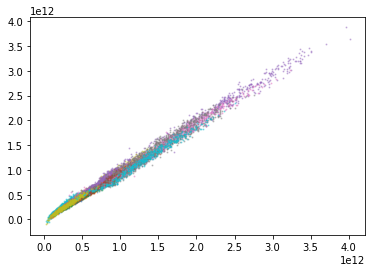

In [29]:
%run /home/user/besos/Matthias/tools/imports.ipynb
scores = np.ndarray((20,3))
y_true_list = []
y_pred_list = []
for i, city in enumerate(CAN_cities.keys()):
    X_test, y_test = read_samples(region=city, param_set=23, output_meter = 'DistrictHeating:Facility')
    X_test, y_test, _ = preprocess(pd.concat([X_test.iloc[:,:13], X_test.iloc[:,17]], axis=1), y_test, standardization)
    y_pred_test = estimator.predict(X_test, verbose=0)
    y_true = standardization[1].inverse_transform(y_test.reshape(len(X_test)))
    y_pred = standardization[1].inverse_transform(y_pred_test.reshape(len(X_test)))
    scores[i, 0] = r2_score(y_true, y_pred) * 100
    scores[i, 1] = MAPE(y_true, y_pred)
    scores[i, 2] = RMSPE(y_true, y_pred)
    y_true_list.append(y_true)
    y_pred_list.append(y_pred)
    plt.scatter(y_true, y_pred, s=1, alpha=0.4)
    print(f'{city:15s} R2 score: {scores[i, 0]:8.2f} %, MAPE: {scores[i, 1]:6.2f} %, RMSPE: {scores[i, 2]:5.2f} %.')

print()
print(f'{"Mean":15s} R2 score: {np.mean(scores[:,0]):8.2f} %, MAPE: {np.mean(scores[:,1]):6.2f} %, RMSPE: {np.mean(scores[:,2]):5.2f} %.')

In [40]:
a = [i for i in y_pred_list]

In [43]:
a = np.concatenate(y_pred_list).ravel().tolist()
b = np.concatenate(y_true_list).ravel().tolist()

In [45]:
r2_score(b,a)

0.9852036197377336